In [1]:
!git clone https://github.com/Kasper-Raupach-Haurum/M4-Deep-learning-portfolio.git

Cloning into 'M4-Deep-learning-portfolio'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 32 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), 7.20 MiB | 7.34 MiB/s, done.


Task 1: Spatial prediction problem

In [ ]:
data = pol_tweets = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz')

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters of the model
num_epochs = 4
batch_size = 4
learning_rate = 0.003

In [ ]:
#I am using https://wandb.ai/site as my performance visualisation tool.
#import wandb
#wandb.init(project="lecture CNN", entity="xxx")
#wandb.config = {
#  "learning_rate": learning_rate,
#  "epochs": num_epochs,
#  "batch_size": batch_size
#}


In [ ]:
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
#DOWNLOAD DATASET 
train_dataset = torchvision.datasets.CIFAR10(root = 'https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz', train=True,
                                            download=True, transform=transform)


test_dataset = torchvision.datasets.CIFAR10(root = 'https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz', train=False,
                                            download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz/cifar-10-python.tar.gz to https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz
Files already downloaded and verified


1st variation of the CNN: Republican key words predictor

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

classes = ('trump', 'forthepeople', 'climate', 'black', 'crisis', 'democracy', 'heroesact', 'china', 'democrats', 'inittogether')

In [ ]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [2000/12500], Loss: 2.3242
Epoch [1/4], Step [4000/12500], Loss: 1.7173
Epoch [1/4], Step [6000/12500], Loss: 1.8615
Epoch [1/4], Step [8000/12500], Loss: 2.0165
Epoch [1/4], Step [10000/12500], Loss: 1.2705
Epoch [1/4], Step [12000/12500], Loss: 2.2961
Epoch [2/4], Step [2000/12500], Loss: 1.1585
Epoch [2/4], Step [4000/12500], Loss: 1.4549
Epoch [2/4], Step [6000/12500], Loss: 1.3348
Epoch [2/4], Step [8000/12500], Loss: 1.3415
Epoch [2/4], Step [10000/12500], Loss: 1.8005
Epoch [2/4], Step [12000/12500], Loss: 1.0582
Epoch [3/4], Step [2000/12500], Loss: 1.2610
Epoch [3/4], Step [4000/12500], Loss: 1.9465
Epoch [3/4], Step [6000/12500], Loss: 0.9293
Epoch [3/4], Step [8000/12500], Loss: 1.3141
Epoch [3/4], Step [10000/12500], Loss: 0.7463
Epoch [3/4], Step [12000/12500], Loss: 1.8606
Epoch [4/4], Step [2000/12500], Loss: 1.1435
Epoch [4/4], Step [4000/12500], Loss: 2.4889
Epoch [4/4], Step [6000/12500], Loss: 1.4189
Epoch [4/4], Step [8000/12500], Loss: 0.5892
Epoc

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 54.58 %
Accuracy of trump: 74.5 %
Accuracy of forthepeople: 67.5 %
Accuracy of climate: 46.8 %
Accuracy of black: 36.5 %
Accuracy of crisis: 38.9 %
Accuracy of democracy: 35.8 %
Accuracy of heroesact: 72.3 %
Accuracy of china: 63.0 %
Accuracy of democrats: 53.0 %
Accuracy of 	inittogether: 57.5 %


When compared to the Module 1: Democrat/Republican tweets NLP we made on the first semester, the accuracy of the CNN network seems to be nearly the same on many of the key words used by the republican tweeters, which would point in the direction of the CNN neural network working effectively

2st variation of the CNN: Republican key words predictor

Task 2: Sequential problem

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

classes = ('biden', 'inittogether', 'dems', '	paycheckprotectionprogram', 'obama', 'congress', 'latinx', 'wellfare', 'diversity', 'lgbtq')

In [ ]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Tesla Stock Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/M4-Deep-learning-portfolio/Tesla New.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2015,222.869995,223.250000,213.259995,219.309998,219.309998,4764400
1,1/5/2015,214.550003,216.500000,207.160004,210.089996,210.089996,5368500
2,1/6/2015,210.059998,214.199997,204.210007,211.279999,211.279999,6261900
3,1/7/2015,213.350006,214.779999,209.779999,210.949997,210.949997,2968400
4,1/8/2015,212.809998,213.800003,210.009995,210.619995,210.619995,3442500


In [6]:
df.shape

(556, 7)

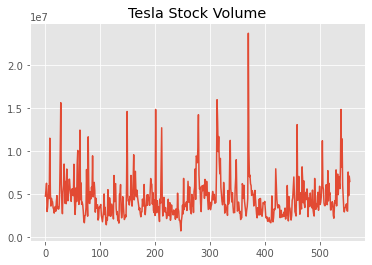

In [7]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Tesla Stock Volume')

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 

In [ ]:
y

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [ ]:
#first 420 for training

X_train = X_ss[:420, :]
X_test = X_ss[420:, :]

y_train = y_mm[:420, :]
y_test = y_mm[420:, :] 

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

In [ ]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

1st set of hyperparameter

In [ ]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 16
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

In [ ]:
# Initializing Hyperparameters
num_epochs = 1000
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        # Initialize the hidden state and the cell state
        # The hidden state and the cell state reset to zero for every epoch
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

In [ ]:
output_list = []
for i, (data, label) in enumerate(test_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])

In [ ]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

2nd set of hyperparameter

In [ ]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 16
output_size = 3
num_epochs= 50

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

In [ ]:
# Initializing Hyperparameters
num_epochs = 1000
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        # Initialize the hidden state and the cell state
        # The hidden state and the cell state reset to zero for every epoch
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

In [ ]:
output_list = []
for i, (data, label) in enumerate(test_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])

In [ ]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))